In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np

# -----------------------------
# 1. Data Preprocessing
# -----------------------------
data_dir = "/kaggle/input/ju-cricket/Cricket_Dataset_final/Task_B"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(f"{data_dir}/train/Bowling", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val/Bowling", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test/Bowling", transform=transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

classes = train_ds.classes
print("Classes:", classes)

Classes: ['fast_bowl', 'spin_bowl']


In [2]:
print("Total training images:", len(train_ds))
print("Total validation images:", len(val_ds))
print("Total test images:", len(test_ds))

total_images = len(train_ds) + len(val_ds) + len(test_ds)
print("Total images in dataset:", total_images)

Total training images: 1710
Total validation images: 432
Total test images: 549
Total images in dataset: 2691


In [3]:
ignore_folder = "random_occlusion"

def count_images_ignore_folder(dataset, ignore_folder):
    count = 0
    for img_path, label in dataset.samples:
        # Skip if the image path contains the ignore_folder
        if ignore_folder not in img_path.split("/"):
            count += 1
    return count

train_count = count_images_ignore_folder(train_ds, ignore_folder)
val_count   = count_images_ignore_folder(val_ds, ignore_folder)
test_count  = count_images_ignore_folder(test_ds, ignore_folder)

total_count = train_count + val_count + test_count

print("Training images (excluding '{}'): {}".format(ignore_folder, train_count))
print("Validation images (excluding '{}'): {}".format(ignore_folder, val_count))
print("Test images (excluding '{}'): {}".format(ignore_folder, test_count))
print("Total images (excluding '{}'): {}".format(ignore_folder, total_count))

Training images (excluding 'random_occlusion'): 1520
Validation images (excluding 'random_occlusion'): 384
Test images (excluding 'random_occlusion'): 488
Total images (excluding 'random_occlusion'): 2392


In [4]:
ignore_folder = "random_occlusionw"

def get_included_folders(dataset, ignore_folder):
    included = set()
    for img_path, label in dataset.samples:
        # Split the path into parts and ignore if ignore_folder is in the path
        if ignore_folder not in img_path.split("/"):
            # The folder name just above the image (or the class folder)
            folder_name = img_path.split("/")[-2]
            included.add(folder_name)
    return included

train_folders = get_included_folders(train_ds, ignore_folder)
val_folders   = get_included_folders(val_ds, ignore_folder)
test_folders  = get_included_folders(test_ds, ignore_folder)

print("Training folders considered:", train_folders)
print("Validation folders considered:", val_folders)
print("Test folders considered:", test_folders)

Training folders considered: {'random_occlusion', 'chromatic_aberration', 'gaussian_noise', 'motion_blur', 'blur', 'lens_flare', 'low_resolution', 'dirty_lens', 'original'}
Validation folders considered: {'random_occlusion', 'chromatic_aberration', 'gaussian_noise', 'motion_blur', 'blur', 'lens_flare', 'low_resolution', 'dirty_lens', 'original'}
Test folders considered: {'random_occlusion', 'chromatic_aberration', 'gaussian_noise', 'motion_blur', 'blur', 'lens_flare', 'low_resolution', 'dirty_lens', 'original'}


In [5]:
ignore_folder = "random_occlusion"

def filter_samples(dataset, ignore_folder):
    # Keep only samples where ignore_folder is NOT in the path
    filtered_samples = [s for s in dataset.samples if ignore_folder not in s[0].split("/")]
    dataset.samples = filtered_samples
    dataset.targets = [s[1] for s in filtered_samples]  # Update targets accordingly
    return dataset

# Create original datasets
train_ds = datasets.ImageFolder(f"{data_dir}/train/Bowling", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val/Bowling", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test/Bowling", transform=transform)

# Filter out 'random_occlusion' folder
train_ds = filter_samples(train_ds, ignore_folder)
val_ds   = filter_samples(val_ds, ignore_folder)
test_ds  = filter_samples(test_ds, ignore_folder)

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

# Classes (will remain the same)
classes = train_ds.classes
print("Classes:", classes)

# Show counts
print("Final Training images:", len(train_ds))
print("Final Validation images:", len(val_ds))
print("Final Test images:", len(test_ds))
print("Total images after filtering:", len(train_ds) + len(val_ds) + len(test_ds))

Classes: ['fast_bowl', 'spin_bowl']
Final Training images: 1520
Final Validation images: 384
Final Test images: 488
Total images after filtering: 2392


In [6]:
ignore_folder = "random_occlusion"

def get_included_folders(dataset, ignore_folder):
    included = set()
    for img_path, label in dataset.samples:
        # Split the path into parts and ignore if ignore_folder is in the path
        if ignore_folder not in img_path.split("/"):
            # The folder name just above the image (or the class folder)
            folder_name = img_path.split("/")[-2]
            included.add(folder_name)
    return included

train_folders = get_included_folders(train_ds, ignore_folder)
val_folders   = get_included_folders(val_ds, ignore_folder)
test_folders  = get_included_folders(test_ds, ignore_folder)

print("Training folders considered:", train_folders)
print("Validation folders considered:", val_folders)
print("Test folders considered:", test_folders)

Training folders considered: {'chromatic_aberration', 'gaussian_noise', 'motion_blur', 'blur', 'lens_flare', 'low_resolution', 'dirty_lens', 'original'}
Validation folders considered: {'chromatic_aberration', 'gaussian_noise', 'motion_blur', 'blur', 'lens_flare', 'low_resolution', 'dirty_lens', 'original'}
Test folders considered: {'chromatic_aberration', 'gaussian_noise', 'motion_blur', 'blur', 'lens_flare', 'low_resolution', 'dirty_lens', 'original'}


In [7]:
# -----------------------------
# 2. Define Swin Transformer Model from Scratch
# -----------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchsummary import summary
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
from tqdm import tqdm
import time
import math
from typing import Optional

def window_partition(x, window_size):
    """
    Partition into non-overlapping windows
    Args:
        x: (B, H, W, C)
        window_size (int): window size
    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows

def window_reverse(windows, window_size, H, W):
    """
    Reverse window partition
    Args:
        windows: (num_windows*B, window_size, window_size, C)
        window_size (int): Window size
        H (int): Height of image
        W (int): Width of image
    Returns:
        x: (B, H, W, C)
    """
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x

class PatchEmbedding(nn.Module):
    """Image to Patch Embedding"""
    def __init__(self, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        self.patch_size = patch_size
        self.in_chans = in_chans
        self.embed_dim = embed_dim
        
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.norm = norm_layer(embed_dim) if norm_layer else None
        
    def forward(self, x):
        """Forward function."""
        # padding
        _, _, H, W = x.size()
        if W % self.patch_size != 0:
            x = F.pad(x, (0, self.patch_size - W % self.patch_size))
        if H % self.patch_size != 0:
            x = F.pad(x, (0, 0, 0, self.patch_size - H % self.patch_size))
            
        x = self.proj(x)  # B C Wh Ww
        if self.norm is not None:
            Wh, Ww = x.size(2), x.size(3)
            x = x.flatten(2).transpose(1, 2)
            x = self.norm(x)
            x = x.transpose(1, 2).view(-1, self.embed_dim, Wh, Ww)
        return x

class PatchMerging(nn.Module):
    """Patch Merging Layer"""
    def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)
    
    def forward(self, x):
        """
        x: B, H*W, C
        """
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"
        assert H % 2 == 0 and W % 2 == 0, f"x size ({H}*{W}) are not even."
        
        x = x.view(B, H, W, C)
        
        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
        x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
        x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
        x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C
        x = torch.cat([x0, x1, x2, x3], -1)  # B H/2 W/2 4*C
        x = x.view(B, -1, 4 * C)  # B H/2*W/2 4*C
        
        x = self.norm(x)
        x = self.reduction(x)
        
        return x

class WindowAttention(nn.Module):
    """Window based multi-head self attention (W-MSA) module with relative position bias"""
    def __init__(self, dim, window_size, num_heads, qkv_bias=True, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.dim = dim
        self.window_size = window_size  # Wh, Ww
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5
        
        # define a parameter table of relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))  # 2*Wh-1 * 2*Ww-1, nH
        
        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w], indexing='ij'))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
        relative_coords[:, :, 0] += self.window_size[0] - 1  # shift to start from 0
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        self.register_buffer("relative_position_index", relative_position_index)
        
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
        
        nn.init.trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, x, mask: Optional[torch.Tensor] = None):
        """
        Args:
            x: input features with shape of (num_windows*B, N, C)
            mask: (0/-inf) mask with shape of (num_windows, Wh*Ww, Wh*Ww) or None
        """
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)
        
        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))
        
        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
        attn = attn + relative_position_bias.unsqueeze(0)
        
        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)
            
        attn = self.attn_drop(attn)
        
        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

class SwinTransformerBlock(nn.Module):
    """Swin Transformer Block"""
    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if min(self.input_resolution) <= self.window_size:
            # if window size is larger than input resolution, we don't partition windows
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"
        
        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim, window_size=(self.window_size, self.window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, attn_drop=attn_drop, proj_drop=drop)
        
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)
        
        if self.shift_size > 0:
            # calculate attention mask for SW-MSA
            H, W = self.input_resolution
            img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
            h_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            w_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    img_mask[:, h, w, :] = cnt
                    cnt += 1
                    
            mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
            mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
            attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
            attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        else:
            attn_mask = None
            
        self.register_buffer("attn_mask", attn_mask)
    
    def forward(self, x):
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"
        
        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)
        
        # cyclic shift
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x = x
            
        # partition windows
        x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)  # nW*B, window_size*window_size, C
        
        # W-MSA/SW-MSA
        attn_windows = self.attn(x_windows, mask=self.attn_mask)  # nW*B, window_size*window_size, C
        
        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)  # B H' W' C
        
        # reverse cyclic shift
        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x
        x = x.view(B, H * W, C)
        
        # FFN
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        
        return x

class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks)."""
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        if self.drop_prob == 0. or not self.training:
            return x
        keep_prob = 1 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
        random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
        random_tensor.floor_()  # binarize
        output = x.div(keep_prob) * random_tensor
        return output

class Mlp(nn.Module):
    """Multi-Layer Perceptron"""
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class BasicLayer(nn.Module):
    """A basic Swin Transformer layer for one stage"""
    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, downsample=None, use_checkpoint=False):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint
        
        # build blocks
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(
                dim=dim, input_resolution=input_resolution,
                num_heads=num_heads, window_size=window_size,
                shift_size=0 if (i % 2 == 0) else window_size // 2,
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                drop=drop, attn_drop=attn_drop,
                drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                norm_layer=norm_layer)
            for i in range(depth)])
        
        # patch merging layer
        if downsample is not None:
            self.downsample = downsample(input_resolution, dim=dim, norm_layer=norm_layer)
        else:
            self.downsample = None
            
    def forward(self, x):
        for blk in self.blocks:
            x = blk(x)
        if self.downsample is not None:
            x = self.downsample(x)
        return x

class MySwinTransformer(nn.Module):
    """Swin Transformer Implementation from Scratch"""
    def __init__(self, img_size=224, patch_size=4, in_chans=3, num_classes=4,
                 embed_dim=96, depths=[2, 2, 6, 2], num_heads=[3, 6, 12, 24],
                 window_size=7, mlp_ratio=4., qkv_bias=True,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
                 norm_layer=nn.LayerNorm, ape=False, patch_norm=True, use_checkpoint=False):
        super().__init__()
        
        self.num_classes = num_classes
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.ape = ape
        self.patch_norm = patch_norm
        self.num_features = int(embed_dim * 2 ** (self.num_layers - 1))
        self.mlp_ratio = mlp_ratio
        
        # split image into non-overlapping patches
        self.patch_embed = PatchEmbedding(
            patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)
        num_patches = self.patch_embed.num_patches = (img_size // patch_size) ** 2
        patches_resolution = self.patch_embed.patches_resolution = [img_size // patch_size, img_size // patch_size]
        self.patches_resolution = patches_resolution
        
        # absolute position embedding
        if self.ape:
            self.absolute_pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
            nn.init.trunc_normal_(self.absolute_pos_embed, std=.02)
            
        self.pos_drop = nn.Dropout(p=drop_rate)
        
        # stochastic depth
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule
        
        # build layers
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = BasicLayer(
                dim=int(embed_dim * 2 ** i_layer),
                input_resolution=(patches_resolution[0] // (2 ** i_layer),
                                  patches_resolution[1] // (2 ** i_layer)),
                depth=depths[i_layer],
                num_heads=num_heads[i_layer],
                window_size=window_size,
                mlp_ratio=self.mlp_ratio,
                qkv_bias=qkv_bias,
                drop=drop_rate,
                attn_drop=attn_drop_rate,
                drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],
                norm_layer=norm_layer,
                downsample=PatchMerging if (i_layer < self.num_layers - 1) else None,
                use_checkpoint=use_checkpoint)
            self.layers.append(layer)
            
        self.norm = norm_layer(self.num_features)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.head = nn.Linear(self.num_features, num_classes) if num_classes > 0 else nn.Identity()
        
        self.apply(self._init_weights)
    
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
            
    def forward(self, x):
        x = self.patch_embed(x)
        if self.ape:
            x = x + self.absolute_pos_embed
        x = self.pos_drop(x)
        
        # Flatten for transformer blocks
        x = x.flatten(2).transpose(1, 2)  # B Ph*Pw C
        
        for layer in self.layers:
            x = layer(x)
            
        x = self.norm(x)  # B L C
        x = self.avgpool(x.transpose(1, 2))  # B C 1
        x = torch.flatten(x, 1)
        x = self.head(x)
        return x

In [8]:
# -----------------------------
# 3. Training Setup
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Swin-Tiny configuration
model = MySwinTransformer(
    img_size=224,
    patch_size=4,
    in_chans=3,
    num_classes=len(classes),
    embed_dim=96,
    depths=[2, 2, 6, 2],
    num_heads=[3, 6, 12, 24],
    window_size=7,
    mlp_ratio=4.0,
    qkv_bias=True,
    drop_rate=0.0,
    attn_drop_rate=0.0,
    drop_path_rate=0.1,
    norm_layer=nn.LayerNorm,
    ape=False,
    patch_norm=True,
    use_checkpoint=False
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.05)

print("Swin Transformer Model Summary:")
try:
    summary(model, (3, 224, 224))
except:
    print("Model summary generation failed - this is normal for complex architectures")
    print(f"Model created successfully with {sum(p.numel() for p in model.parameters()):,} parameters")

Swin Transformer Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 56, 56]           4,704
         LayerNorm-2             [-1, 3136, 96]             192
    PatchEmbedding-3           [-1, 96, 56, 56]               0
           Dropout-4           [-1, 96, 56, 56]               0
         LayerNorm-5             [-1, 3136, 96]             192
            Linear-6              [-1, 49, 288]          27,936
           Softmax-7            [-1, 3, 49, 49]               0
           Dropout-8            [-1, 3, 49, 49]               0
            Linear-9               [-1, 49, 96]           9,312
          Dropout-10               [-1, 49, 96]               0
  WindowAttention-11               [-1, 49, 96]               0
         Identity-12             [-1, 3136, 96]               0
        LayerNorm-13             [-1, 3136, 96]             192
       


🚀 Starting Swin Transformer Training for 50 epochs...

📈 Epoch 1/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:40<00:00,  1.18it/s, Loss=1.0000, Acc=0.5664]


✅ Training completed in 40.66s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.07it/s, Loss=0.6813, Acc=0.5781]


✅ Validation completed in 5.80s
🌟 New best Swin Transformer model found! Validation Accuracy: 0.5781

📊 Epoch 1 Summary:
│ Train Loss: 1.0000 | Train Acc: 0.5664
│ Val Loss:   0.6813 | Val Acc:   0.5781
│ Train Time: 40.66s | Val Time: 5.80s
│ Total Epoch Time: 46.46s
│ Best Val Acc: 0.5781 (Epoch 1)
│ GPU Memory: 0.5GB / 4.0GB

📈 Epoch 2/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:34<00:00,  1.39it/s, Loss=0.6785, Acc=0.5803]


✅ Training completed in 34.48s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:04<00:00,  2.89it/s, Loss=0.7826, Acc=0.4818]


✅ Validation completed in 4.16s

📊 Epoch 2 Summary:
│ Train Loss: 0.6785 | Train Acc: 0.5803
│ Val Loss:   0.7826 | Val Acc:   0.4818
│ Train Time: 34.48s | Val Time: 4.16s
│ Total Epoch Time: 38.64s
│ Best Val Acc: 0.5781 (Epoch 1)
│ GPU Memory: 0.5GB / 4.0GB

📈 Epoch 3/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:34<00:00,  1.39it/s, Loss=0.6629, Acc=0.6197]


✅ Training completed in 34.61s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.05it/s, Loss=0.7037, Acc=0.6172]


✅ Validation completed in 3.94s
🌟 New best Swin Transformer model found! Validation Accuracy: 0.6172

📊 Epoch 3 Summary:
│ Train Loss: 0.6629 | Train Acc: 0.6197
│ Val Loss:   0.7037 | Val Acc:   0.6172
│ Train Time: 34.61s | Val Time: 3.94s
│ Total Epoch Time: 38.56s
│ Best Val Acc: 0.6172 (Epoch 3)
│ GPU Memory: 0.5GB / 4.0GB

📈 Epoch 4/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:34<00:00,  1.39it/s, Loss=0.6691, Acc=0.6171]


✅ Training completed in 34.56s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:04<00:00,  2.96it/s, Loss=0.6777, Acc=0.6250]


✅ Validation completed in 4.06s
🌟 New best Swin Transformer model found! Validation Accuracy: 0.6250

📊 Epoch 4 Summary:
│ Train Loss: 0.6691 | Train Acc: 0.6171
│ Val Loss:   0.6777 | Val Acc:   0.6250
│ Train Time: 34.56s | Val Time: 4.06s
│ Total Epoch Time: 38.62s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 0.5GB / 4.0GB

📈 Epoch 5/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:35<00:00,  1.37it/s, Loss=0.6955, Acc=0.5783]


✅ Training completed in 35.01s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:04<00:00,  2.97it/s, Loss=0.6636, Acc=0.6250]


✅ Validation completed in 4.04s

📊 Epoch 5 Summary:
│ Train Loss: 0.6955 | Train Acc: 0.5783
│ Val Loss:   0.6636 | Val Acc:   0.6250
│ Train Time: 35.01s | Val Time: 4.04s
│ Total Epoch Time: 39.05s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 0.5GB / 4.0GB

📈 Epoch 6/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:34<00:00,  1.39it/s, Loss=0.6765, Acc=0.6112]


✅ Training completed in 34.61s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.03it/s, Loss=0.6681, Acc=0.6250]


✅ Validation completed in 3.97s

📊 Epoch 6 Summary:
│ Train Loss: 0.6765 | Train Acc: 0.6112
│ Val Loss:   0.6681 | Val Acc:   0.6250
│ Train Time: 34.61s | Val Time: 3.97s
│ Total Epoch Time: 38.58s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 0.5GB / 4.0GB

📈 Epoch 7/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:34<00:00,  1.39it/s, Loss=0.6826, Acc=0.5763]


✅ Training completed in 34.56s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.02it/s, Loss=0.6779, Acc=0.6250]


✅ Validation completed in 3.98s

📊 Epoch 7 Summary:
│ Train Loss: 0.6826 | Train Acc: 0.5763
│ Val Loss:   0.6779 | Val Acc:   0.6250
│ Train Time: 34.56s | Val Time: 3.98s
│ Total Epoch Time: 38.54s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 0.5GB / 4.0GB

📈 Epoch 8/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:34<00:00,  1.39it/s, Loss=0.6738, Acc=0.6138]


✅ Training completed in 34.47s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.03it/s, Loss=0.6621, Acc=0.6250]


✅ Validation completed in 3.97s

📊 Epoch 8 Summary:
│ Train Loss: 0.6738 | Train Acc: 0.6138
│ Val Loss:   0.6621 | Val Acc:   0.6250
│ Train Time: 34.47s | Val Time: 3.97s
│ Total Epoch Time: 38.44s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 0.5GB / 4.0GB

📈 Epoch 9/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:34<00:00,  1.40it/s, Loss=0.6891, Acc=0.5401]


✅ Training completed in 34.37s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:04<00:00,  2.96it/s, Loss=0.6630, Acc=0.6250]


✅ Validation completed in 4.06s

📊 Epoch 9 Summary:
│ Train Loss: 0.6891 | Train Acc: 0.5401
│ Val Loss:   0.6630 | Val Acc:   0.6250
│ Train Time: 34.37s | Val Time: 4.06s
│ Total Epoch Time: 38.43s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 0.5GB / 4.0GB

📈 Epoch 10/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:34<00:00,  1.39it/s, Loss=0.6679, Acc=0.6263]


✅ Training completed in 34.47s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.05it/s, Loss=0.6630, Acc=0.6250]


✅ Validation completed in 3.94s

📊 Epoch 10 Summary:
│ Train Loss: 0.6679 | Train Acc: 0.6263
│ Val Loss:   0.6630 | Val Acc:   0.6250
│ Train Time: 34.47s | Val Time: 3.94s
│ Total Epoch Time: 38.42s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 0.5GB / 4.0GB

📈 Epoch 11/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:34<00:00,  1.39it/s, Loss=0.6832, Acc=0.5776]


✅ Training completed in 34.51s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.06it/s, Loss=0.6678, Acc=0.6250]


✅ Validation completed in 3.93s

📊 Epoch 11 Summary:
│ Train Loss: 0.6832 | Train Acc: 0.5776
│ Val Loss:   0.6678 | Val Acc:   0.6250
│ Train Time: 34.51s | Val Time: 3.93s
│ Total Epoch Time: 38.44s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 0.5GB / 4.0GB

📈 Epoch 12/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:34<00:00,  1.39it/s, Loss=0.6668, Acc=0.6257]


✅ Training completed in 34.52s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.03it/s, Loss=0.6626, Acc=0.6250]


✅ Validation completed in 3.97s

📊 Epoch 12 Summary:
│ Train Loss: 0.6668 | Train Acc: 0.6257
│ Val Loss:   0.6626 | Val Acc:   0.6250
│ Train Time: 34.52s | Val Time: 3.97s
│ Total Epoch Time: 38.49s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 0.5GB / 4.0GB

📈 Epoch 13/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:34<00:00,  1.39it/s, Loss=0.6701, Acc=0.6263]


✅ Training completed in 34.44s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:04<00:00,  2.92it/s, Loss=0.6711, Acc=0.6250]


✅ Validation completed in 4.12s

📊 Epoch 13 Summary:
│ Train Loss: 0.6701 | Train Acc: 0.6263
│ Val Loss:   0.6711 | Val Acc:   0.6250
│ Train Time: 34.44s | Val Time: 4.12s
│ Total Epoch Time: 38.56s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 0.5GB / 4.0GB

📈 Epoch 14/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:34<00:00,  1.39it/s, Loss=0.6691, Acc=0.6224]


✅ Training completed in 34.52s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.04it/s, Loss=0.6649, Acc=0.6250]


✅ Validation completed in 3.96s

📊 Epoch 14 Summary:
│ Train Loss: 0.6691 | Train Acc: 0.6224
│ Val Loss:   0.6649 | Val Acc:   0.6250
│ Train Time: 34.52s | Val Time: 3.96s
│ Total Epoch Time: 38.48s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 0.5GB / 4.0GB

📈 Epoch 15/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:34<00:00,  1.40it/s, Loss=0.6654, Acc=0.6263]


✅ Training completed in 34.25s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.04it/s, Loss=0.6661, Acc=0.6250]


✅ Validation completed in 3.95s

📊 Epoch 15 Summary:
│ Train Loss: 0.6654 | Train Acc: 0.6263
│ Val Loss:   0.6661 | Val Acc:   0.6250
│ Train Time: 34.25s | Val Time: 3.95s
│ Total Epoch Time: 38.20s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 0.5GB / 4.0GB

📈 Epoch 16/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:34<00:00,  1.39it/s, Loss=0.6636, Acc=0.6263]


✅ Training completed in 34.62s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.04it/s, Loss=0.6629, Acc=0.6250]


✅ Validation completed in 3.95s

📊 Epoch 16 Summary:
│ Train Loss: 0.6636 | Train Acc: 0.6263
│ Val Loss:   0.6629 | Val Acc:   0.6250
│ Train Time: 34.62s | Val Time: 3.95s
│ Total Epoch Time: 38.58s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 0.5GB / 4.0GB

📈 Epoch 17/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:34<00:00,  1.40it/s, Loss=0.6640, Acc=0.6263]


✅ Training completed in 34.38s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.05it/s, Loss=0.6680, Acc=0.6250]


✅ Validation completed in 3.94s

📊 Epoch 17 Summary:
│ Train Loss: 0.6640 | Train Acc: 0.6263
│ Val Loss:   0.6680 | Val Acc:   0.6250
│ Train Time: 34.38s | Val Time: 3.94s
│ Total Epoch Time: 38.31s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 0.5GB / 4.0GB

📈 Epoch 18/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:34<00:00,  1.38it/s, Loss=0.6673, Acc=0.6263]


✅ Training completed in 34.90s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:04<00:00,  2.99it/s, Loss=0.6771, Acc=0.6250]


✅ Validation completed in 4.02s

📊 Epoch 18 Summary:
│ Train Loss: 0.6673 | Train Acc: 0.6263
│ Val Loss:   0.6771 | Val Acc:   0.6250
│ Train Time: 34.90s | Val Time: 4.02s
│ Total Epoch Time: 38.92s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 0.5GB / 4.0GB

📈 Epoch 19/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:34<00:00,  1.39it/s, Loss=0.6678, Acc=0.6270]


✅ Training completed in 34.54s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:04<00:00,  2.98it/s, Loss=0.6633, Acc=0.6250]


✅ Validation completed in 4.03s

📊 Epoch 19 Summary:
│ Train Loss: 0.6678 | Train Acc: 0.6270
│ Val Loss:   0.6633 | Val Acc:   0.6250
│ Train Time: 34.54s | Val Time: 4.03s
│ Total Epoch Time: 38.57s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 0.5GB / 4.0GB

📈 Epoch 20/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:34<00:00,  1.37it/s, Loss=0.6617, Acc=0.6263]


✅ Training completed in 34.98s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:04<00:00,  2.99it/s, Loss=0.6619, Acc=0.6250]


✅ Validation completed in 4.02s

📊 Epoch 20 Summary:
│ Train Loss: 0.6617 | Train Acc: 0.6263
│ Val Loss:   0.6619 | Val Acc:   0.6250
│ Train Time: 34.98s | Val Time: 4.02s
│ Total Epoch Time: 39.00s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 0.5GB / 4.0GB

📈 Epoch 21/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:34<00:00,  1.39it/s, Loss=0.6657, Acc=0.6263]


✅ Training completed in 34.56s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:04<00:00,  2.71it/s, Loss=0.6631, Acc=0.6250]


✅ Validation completed in 4.43s

📊 Epoch 21 Summary:
│ Train Loss: 0.6657 | Train Acc: 0.6263
│ Val Loss:   0.6631 | Val Acc:   0.6250
│ Train Time: 34.56s | Val Time: 4.43s
│ Total Epoch Time: 38.99s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 0.5GB / 4.0GB

📈 Epoch 22/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:34<00:00,  1.38it/s, Loss=0.6677, Acc=0.6204]


✅ Training completed in 34.71s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.02it/s, Loss=0.6751, Acc=0.6250]


✅ Validation completed in 3.98s

📊 Epoch 22 Summary:
│ Train Loss: 0.6677 | Train Acc: 0.6204
│ Val Loss:   0.6751 | Val Acc:   0.6250
│ Train Time: 34.71s | Val Time: 3.98s
│ Total Epoch Time: 38.69s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 0.5GB / 4.0GB

📈 Epoch 23/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:34<00:00,  1.39it/s, Loss=0.6685, Acc=0.6250]


✅ Training completed in 34.63s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.01it/s, Loss=0.6640, Acc=0.6250]


✅ Validation completed in 3.98s

📊 Epoch 23 Summary:
│ Train Loss: 0.6685 | Train Acc: 0.6250
│ Val Loss:   0.6640 | Val Acc:   0.6250
│ Train Time: 34.63s | Val Time: 3.98s
│ Total Epoch Time: 38.61s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 0.5GB / 4.0GB

📈 Epoch 24/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:34<00:00,  1.38it/s, Loss=0.6637, Acc=0.6257]


✅ Training completed in 34.85s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:04<00:00,  2.98it/s, Loss=0.6620, Acc=0.6250]


✅ Validation completed in 4.04s

📊 Epoch 24 Summary:
│ Train Loss: 0.6637 | Train Acc: 0.6257
│ Val Loss:   0.6620 | Val Acc:   0.6250
│ Train Time: 34.85s | Val Time: 4.04s
│ Total Epoch Time: 38.90s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 0.5GB / 4.0GB

📈 Epoch 25/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:34<00:00,  1.38it/s, Loss=0.6687, Acc=0.6270]


✅ Training completed in 34.84s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:04<00:00,  2.99it/s, Loss=0.6653, Acc=0.6250]


✅ Validation completed in 4.02s

📊 Epoch 25 Summary:
│ Train Loss: 0.6687 | Train Acc: 0.6270
│ Val Loss:   0.6653 | Val Acc:   0.6250
│ Train Time: 34.84s | Val Time: 4.02s
│ Total Epoch Time: 38.87s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 0.5GB / 4.0GB

📈 Epoch 26/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:34<00:00,  1.39it/s, Loss=0.6638, Acc=0.6263]


✅ Training completed in 34.59s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:04<00:00,  2.90it/s, Loss=0.6616, Acc=0.6250]


✅ Validation completed in 4.15s

📊 Epoch 26 Summary:
│ Train Loss: 0.6638 | Train Acc: 0.6263
│ Val Loss:   0.6616 | Val Acc:   0.6250
│ Train Time: 34.59s | Val Time: 4.15s
│ Total Epoch Time: 38.74s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 0.5GB / 4.0GB

📈 Epoch 27/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:34<00:00,  1.39it/s, Loss=0.6640, Acc=0.6250]


✅ Training completed in 34.63s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:04<00:00,  2.97it/s, Loss=0.6621, Acc=0.6250]


✅ Validation completed in 4.05s

📊 Epoch 27 Summary:
│ Train Loss: 0.6640 | Train Acc: 0.6250
│ Val Loss:   0.6621 | Val Acc:   0.6250
│ Train Time: 34.63s | Val Time: 4.05s
│ Total Epoch Time: 38.69s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 0.5GB / 4.0GB

📈 Epoch 28/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:34<00:00,  1.39it/s, Loss=0.6672, Acc=0.6263]


✅ Training completed in 34.43s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:04<00:00,  2.99it/s, Loss=0.6624, Acc=0.6250]


✅ Validation completed in 4.03s

📊 Epoch 28 Summary:
│ Train Loss: 0.6672 | Train Acc: 0.6263
│ Val Loss:   0.6624 | Val Acc:   0.6250
│ Train Time: 34.43s | Val Time: 4.03s
│ Total Epoch Time: 38.46s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 0.5GB / 4.0GB

📈 Epoch 29/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:34<00:00,  1.38it/s, Loss=0.6646, Acc=0.6270]


✅ Training completed in 34.77s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:04<00:00,  2.97it/s, Loss=0.6736, Acc=0.6250]


✅ Validation completed in 4.05s

📊 Epoch 29 Summary:
│ Train Loss: 0.6646 | Train Acc: 0.6270
│ Val Loss:   0.6736 | Val Acc:   0.6250
│ Train Time: 34.77s | Val Time: 4.05s
│ Total Epoch Time: 38.82s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 0.5GB / 4.0GB

📈 Epoch 30/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:34<00:00,  1.39it/s, Loss=0.6673, Acc=0.6270]


✅ Training completed in 34.50s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.02it/s, Loss=0.6664, Acc=0.6250]


✅ Validation completed in 3.98s

📊 Epoch 30 Summary:
│ Train Loss: 0.6673 | Train Acc: 0.6270
│ Val Loss:   0.6664 | Val Acc:   0.6250
│ Train Time: 34.50s | Val Time: 3.98s
│ Total Epoch Time: 38.48s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 0.5GB / 4.0GB

📈 Epoch 31/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:34<00:00,  1.39it/s, Loss=0.6672, Acc=0.6270]


✅ Training completed in 34.61s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.08it/s, Loss=0.6647, Acc=0.6250]


✅ Validation completed in 3.91s

📊 Epoch 31 Summary:
│ Train Loss: 0.6672 | Train Acc: 0.6270
│ Val Loss:   0.6647 | Val Acc:   0.6250
│ Train Time: 34.61s | Val Time: 3.91s
│ Total Epoch Time: 38.52s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 0.5GB / 4.0GB

📈 Epoch 32/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:34<00:00,  1.38it/s, Loss=0.6668, Acc=0.6257]


✅ Training completed in 34.72s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:04<00:00,  2.95it/s, Loss=0.6619, Acc=0.6250]


✅ Validation completed in 4.07s

📊 Epoch 32 Summary:
│ Train Loss: 0.6668 | Train Acc: 0.6257
│ Val Loss:   0.6619 | Val Acc:   0.6250
│ Train Time: 34.72s | Val Time: 4.07s
│ Total Epoch Time: 38.80s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 0.5GB / 4.0GB

📈 Epoch 33/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:34<00:00,  1.37it/s, Loss=0.6627, Acc=0.6250]


✅ Training completed in 34.94s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:04<00:00,  2.88it/s, Loss=0.6619, Acc=0.6250]


✅ Validation completed in 4.17s

📊 Epoch 33 Summary:
│ Train Loss: 0.6627 | Train Acc: 0.6250
│ Val Loss:   0.6619 | Val Acc:   0.6250
│ Train Time: 34.94s | Val Time: 4.17s
│ Total Epoch Time: 39.11s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 0.5GB / 4.0GB

📈 Epoch 34/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:34<00:00,  1.38it/s, Loss=0.6663, Acc=0.6224]


✅ Training completed in 34.86s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:04<00:00,  2.99it/s, Loss=0.6616, Acc=0.6250]


✅ Validation completed in 4.03s

📊 Epoch 34 Summary:
│ Train Loss: 0.6663 | Train Acc: 0.6224
│ Val Loss:   0.6616 | Val Acc:   0.6250
│ Train Time: 34.86s | Val Time: 4.03s
│ Total Epoch Time: 38.89s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 0.5GB / 4.0GB

📈 Epoch 35/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:34<00:00,  1.38it/s, Loss=0.6638, Acc=0.6257]


✅ Training completed in 34.68s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:04<00:00,  2.88it/s, Loss=0.6617, Acc=0.6250]


✅ Validation completed in 4.17s

📊 Epoch 35 Summary:
│ Train Loss: 0.6638 | Train Acc: 0.6257
│ Val Loss:   0.6617 | Val Acc:   0.6250
│ Train Time: 34.68s | Val Time: 4.17s
│ Total Epoch Time: 38.86s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 0.5GB / 4.0GB

📈 Epoch 36/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:34<00:00,  1.38it/s, Loss=0.6635, Acc=0.6263]


✅ Training completed in 34.82s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.03it/s, Loss=0.6618, Acc=0.6250]


✅ Validation completed in 3.97s

📊 Epoch 36 Summary:
│ Train Loss: 0.6635 | Train Acc: 0.6263
│ Val Loss:   0.6618 | Val Acc:   0.6250
│ Train Time: 34.82s | Val Time: 3.97s
│ Total Epoch Time: 38.80s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 0.5GB / 4.0GB

📈 Epoch 37/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:34<00:00,  1.38it/s, Loss=0.6651, Acc=0.6217]


✅ Training completed in 34.73s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:04<00:00,  2.93it/s, Loss=0.6616, Acc=0.6250]


✅ Validation completed in 4.11s

📊 Epoch 37 Summary:
│ Train Loss: 0.6651 | Train Acc: 0.6217
│ Val Loss:   0.6616 | Val Acc:   0.6250
│ Train Time: 34.73s | Val Time: 4.11s
│ Total Epoch Time: 38.84s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 0.5GB / 4.0GB

📈 Epoch 38/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:34<00:00,  1.38it/s, Loss=0.6665, Acc=0.6257]


✅ Training completed in 34.73s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:04<00:00,  2.91it/s, Loss=0.6630, Acc=0.6250]


✅ Validation completed in 4.13s

📊 Epoch 38 Summary:
│ Train Loss: 0.6665 | Train Acc: 0.6257
│ Val Loss:   0.6630 | Val Acc:   0.6250
│ Train Time: 34.73s | Val Time: 4.13s
│ Total Epoch Time: 38.86s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 0.5GB / 4.0GB

📈 Epoch 39/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:34<00:00,  1.39it/s, Loss=0.6628, Acc=0.6263]


✅ Training completed in 34.62s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.00it/s, Loss=0.6621, Acc=0.6250]


✅ Validation completed in 4.00s

📊 Epoch 39 Summary:
│ Train Loss: 0.6628 | Train Acc: 0.6263
│ Val Loss:   0.6621 | Val Acc:   0.6250
│ Train Time: 34.62s | Val Time: 4.00s
│ Total Epoch Time: 38.62s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 0.5GB / 4.0GB

📈 Epoch 40/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:34<00:00,  1.39it/s, Loss=0.6635, Acc=0.6263]


✅ Training completed in 34.45s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.01it/s, Loss=0.6633, Acc=0.6250]


✅ Validation completed in 4.00s

📊 Epoch 40 Summary:
│ Train Loss: 0.6635 | Train Acc: 0.6263
│ Val Loss:   0.6633 | Val Acc:   0.6250
│ Train Time: 34.45s | Val Time: 4.00s
│ Total Epoch Time: 38.45s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 0.5GB / 4.0GB

📈 Epoch 41/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:34<00:00,  1.38it/s, Loss=0.6653, Acc=0.6263]


✅ Training completed in 34.67s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:04<00:00,  2.97it/s, Loss=0.6616, Acc=0.6250]


✅ Validation completed in 4.05s

📊 Epoch 41 Summary:
│ Train Loss: 0.6653 | Train Acc: 0.6263
│ Val Loss:   0.6616 | Val Acc:   0.6250
│ Train Time: 34.67s | Val Time: 4.05s
│ Total Epoch Time: 38.73s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 0.5GB / 4.0GB

📈 Epoch 42/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:34<00:00,  1.39it/s, Loss=0.6655, Acc=0.6263]


✅ Training completed in 34.53s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.02it/s, Loss=0.6624, Acc=0.6250]


✅ Validation completed in 3.98s

📊 Epoch 42 Summary:
│ Train Loss: 0.6655 | Train Acc: 0.6263
│ Val Loss:   0.6624 | Val Acc:   0.6250
│ Train Time: 34.53s | Val Time: 3.98s
│ Total Epoch Time: 38.51s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 0.5GB / 4.0GB

📈 Epoch 43/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:34<00:00,  1.39it/s, Loss=0.6649, Acc=0.6263]


✅ Training completed in 34.63s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.01it/s, Loss=0.6649, Acc=0.6250]


✅ Validation completed in 4.00s

📊 Epoch 43 Summary:
│ Train Loss: 0.6649 | Train Acc: 0.6263
│ Val Loss:   0.6649 | Val Acc:   0.6250
│ Train Time: 34.63s | Val Time: 4.00s
│ Total Epoch Time: 38.63s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 0.5GB / 4.0GB

📈 Epoch 44/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:34<00:00,  1.39it/s, Loss=0.6646, Acc=0.6263]


✅ Training completed in 34.55s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:04<00:00,  2.95it/s, Loss=0.6627, Acc=0.6250]


✅ Validation completed in 4.07s

📊 Epoch 44 Summary:
│ Train Loss: 0.6646 | Train Acc: 0.6263
│ Val Loss:   0.6627 | Val Acc:   0.6250
│ Train Time: 34.55s | Val Time: 4.07s
│ Total Epoch Time: 38.62s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 0.5GB / 4.0GB

📈 Epoch 45/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:34<00:00,  1.38it/s, Loss=0.6650, Acc=0.6263]


✅ Training completed in 34.68s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:04<00:00,  2.99it/s, Loss=0.6648, Acc=0.6250]


✅ Validation completed in 4.02s

📊 Epoch 45 Summary:
│ Train Loss: 0.6650 | Train Acc: 0.6263
│ Val Loss:   0.6648 | Val Acc:   0.6250
│ Train Time: 34.68s | Val Time: 4.02s
│ Total Epoch Time: 38.70s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 0.5GB / 4.0GB

📈 Epoch 46/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:34<00:00,  1.39it/s, Loss=0.6611, Acc=0.6263]


✅ Training completed in 34.62s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.04it/s, Loss=0.6616, Acc=0.6250]


✅ Validation completed in 3.96s

📊 Epoch 46 Summary:
│ Train Loss: 0.6611 | Train Acc: 0.6263
│ Val Loss:   0.6616 | Val Acc:   0.6250
│ Train Time: 34.62s | Val Time: 3.96s
│ Total Epoch Time: 38.58s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 0.5GB / 4.0GB

📈 Epoch 47/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:34<00:00,  1.39it/s, Loss=0.6689, Acc=0.6237]


✅ Training completed in 34.50s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:04<00:00,  2.99it/s, Loss=0.6651, Acc=0.6250]


✅ Validation completed in 4.03s

📊 Epoch 47 Summary:
│ Train Loss: 0.6689 | Train Acc: 0.6237
│ Val Loss:   0.6651 | Val Acc:   0.6250
│ Train Time: 34.50s | Val Time: 4.03s
│ Total Epoch Time: 38.54s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 0.5GB / 4.0GB

📈 Epoch 48/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:34<00:00,  1.38it/s, Loss=0.6630, Acc=0.6263]


✅ Training completed in 34.76s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.01it/s, Loss=0.6857, Acc=0.6250]


✅ Validation completed in 4.00s

📊 Epoch 48 Summary:
│ Train Loss: 0.6630 | Train Acc: 0.6263
│ Val Loss:   0.6857 | Val Acc:   0.6250
│ Train Time: 34.76s | Val Time: 4.00s
│ Total Epoch Time: 38.76s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 0.5GB / 4.0GB

📈 Epoch 49/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:34<00:00,  1.38it/s, Loss=0.6639, Acc=0.6263]


✅ Training completed in 34.72s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.03it/s, Loss=0.6628, Acc=0.6250]


✅ Validation completed in 3.96s

📊 Epoch 49 Summary:
│ Train Loss: 0.6639 | Train Acc: 0.6263
│ Val Loss:   0.6628 | Val Acc:   0.6250
│ Train Time: 34.72s | Val Time: 3.96s
│ Total Epoch Time: 38.69s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 0.5GB / 4.0GB

📈 Epoch 50/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:34<00:00,  1.39it/s, Loss=0.6639, Acc=0.6263]


✅ Training completed in 34.62s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:04<00:00,  2.97it/s, Loss=0.6636, Acc=0.6250]


✅ Validation completed in 4.05s

📊 Epoch 50 Summary:
│ Train Loss: 0.6639 | Train Acc: 0.6263
│ Val Loss:   0.6636 | Val Acc:   0.6250
│ Train Time: 34.62s | Val Time: 4.05s
│ Total Epoch Time: 38.67s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 0.5GB / 4.0GB

💾 Best Swin Transformer model saved as 'best_swin_transformer_model.pth'
📊 Best model stats:
│ Best Epoch: 4
│ Best Val Acc: 0.6250

💾 Swin Transformer training history saved to 'swin_transformer_training_history.csv'

🎉 Swin Transformer Training Complete!
Total Training Time: 1940.76s (32.3 minutes)
Average Epoch Time: 38.81s

⏱️  Epoch Timing Breakdown:
│ Epoch 1: 46.46s
│ Epoch 2: 38.64s
│ Epoch 3: 38.56s
│ Epoch 4: 38.62s
│ Epoch 5: 39.05s
│ Epoch 6: 38.58s
│ Epoch 7: 38.54s
│ Epoch 8: 38.44s
│ Epoch 9: 38.43s
│ Epoch 10: 38.42s
│ Epoch 11: 38.44s
│ Epoch 12: 38.49s
│ Epoch 13: 38.56s
│ Epoch 14: 38.48s
│ Epoch 15: 38.20s
│ Epoch 16: 38.58s
│ Epoch 17: 38.31s
│ Epoch 18: 38.92s
│ Epoch 19: 38.57s
│ Epoch 20: 39.00s
│ Epoch 

Testing Swin Transformer: 100%|██████████████████████████████| 16/16 [00:08<00:00,  1.95it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modi

✅ Swin Transformer Testing completed in 8.23s

📋 Swin Transformer Classification Report:
              precision    recall  f1-score   support

   fast_bowl       0.62      1.00      0.77       304
   spin_bowl       0.00      0.00      0.00       184

    accuracy                           0.62       488
   macro avg       0.31      0.50      0.38       488
weighted avg       0.39      0.62      0.48       488

🎯 Swin Transformer Test Accuracy: 0.6230

📊 Swin Transformer Model Performance Summary:
│ Best Validation Acc:  0.6250 (Epoch 4)
│ Final Test Accuracy:  0.6230
│ Val-Test Gap:         0.0020


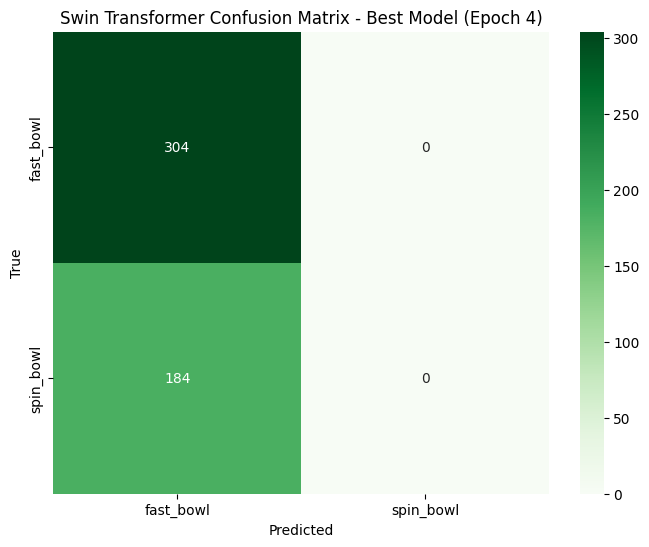

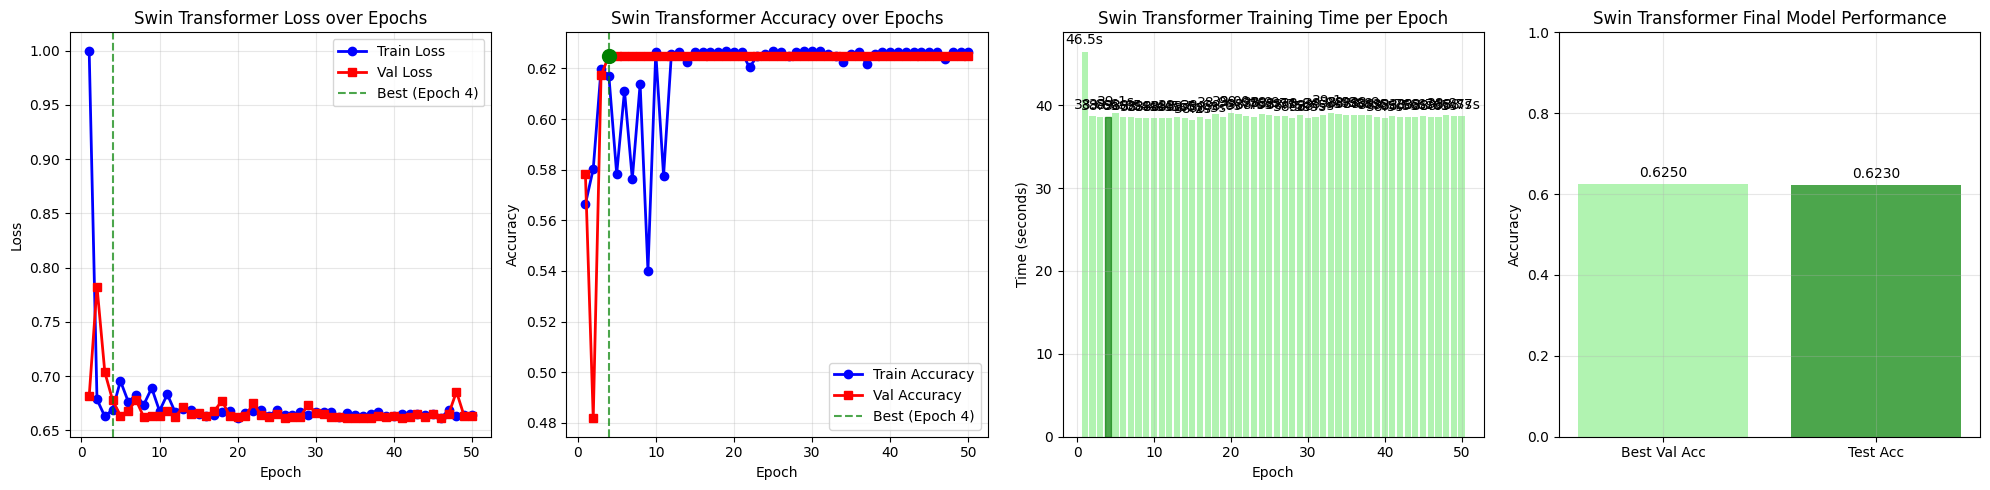


⏰ Swin Transformer Final Timing Summary:
│ Total Training: 1940.76s
│ Average per Epoch: 38.81s
│ Testing Time: 8.23s
│ Total Runtime: 1948.99s

💾 Swin Transformer Files saved:
│ best_swin_transformer_model.pth - Best validation accuracy model
│ swin_transformer_training_history.csv - Training metrics for later plotting

🏗️  Swin Transformer Architecture Summary:
│ Total Parameters: 27,520,892
│ Trainable Parameters: 27,520,892
│ Model Size: 104.98 MB
│ Input Size: 224x224x3
│ Patch Size: 4x4
│ Window Size: 7x7
│ Embed Dimension: 96
│ Depths: [2, 2, 6, 2]
│ Number of Heads: [3, 6, 12, 24]
│ Drop Path Rate: 0.1
│ Output Classes: 2
│ Hierarchical Structure: Yes
│ Shifted Windows: Yes
│ Relative Position Bias: Yes


In [9]:
# -----------------------------
# 4. Training Loop with Best Model Saving (Val Accuracy) - Swin Transformer
# -----------------------------
train_losses, val_losses = [], []
train_accs, val_accs = [], []
epoch_times = []
epochs = 50

# Initialize best model tracking
best_val_acc = 0.0
best_model_state = None
best_epoch = 0

print(f"\n🚀 Starting Swin Transformer Training for {epochs} epochs...")
print("=" * 80)

total_start_time = time.time()

for epoch in range(epochs):
    epoch_start_time = time.time()
    
    print(f"\n📈 Epoch {epoch+1}/{epochs}")
    print("-" * 50)
    
    # Training Phase
    print("🔄 Training Phase...")
    model.train()
    running_loss, correct, total = 0, 0, 0
    
    train_pbar = tqdm(train_loader, desc=f"Training", 
                     bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')
    
    train_phase_start = time.time()
    
    for batch_idx, (imgs, labels) in enumerate(train_pbar):
        imgs, labels = imgs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        
        current_acc = correct / total
        train_pbar.set_postfix({
            'Loss': f'{running_loss/(batch_idx+1):.4f}',
            'Acc': f'{current_acc:.4f}'
        })
        
        if device.type == 'cuda' and batch_idx % 10 == 0:
            gpu_memory = torch.cuda.memory_allocated() / 1024**3
            train_pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{current_acc:.4f}',
                'GPU': f'{gpu_memory:.1f}GB'
            })
    
    train_phase_time = time.time() - train_phase_start
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    print(f"✅ Training completed in {train_phase_time:.2f}s")
    
    # Validation Phase
    print("🔍 Validation Phase...")
    model.eval()
    running_loss, correct, total = 0, 0, 0
    
    val_phase_start = time.time()
    val_pbar = tqdm(val_loader, desc=f"Validation", 
                   bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')
    
    with torch.no_grad():
        for batch_idx, (imgs, labels) in enumerate(val_pbar):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
            current_acc = correct / total
            val_pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{current_acc:.4f}'
            })
    
    val_phase_time = time.time() - val_phase_start
    val_loss = running_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"✅ Validation completed in {val_phase_time:.2f}s")
    
    # Check if this is the best model so far based on val_acc
    is_best = val_acc > best_val_acc
    if is_best:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        best_model_state = model.state_dict().copy()
        print(f"🌟 New best Swin Transformer model found! Validation Accuracy: {val_acc:.4f}")
    
    # Epoch Summary
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)
    
    print(f"\n📊 Epoch {epoch+1} Summary:")
    print(f"│ Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"│ Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    print(f"│ Train Time: {train_phase_time:.2f}s | Val Time: {val_phase_time:.2f}s")
    print(f"│ Total Epoch Time: {epoch_time:.2f}s")
    print(f"│ Best Val Acc: {best_val_acc:.4f} (Epoch {best_epoch})")
    
    if device.type == 'cuda':
        print(f"│ GPU Memory: {torch.cuda.memory_allocated()/1024**3:.1f}GB / {torch.cuda.memory_reserved()/1024**3:.1f}GB")
    
    print("=" * 80)

total_training_time = time.time() - total_start_time

# Save the best model
if best_model_state is not None:
    torch.save(best_model_state, 'best_swin_transformer_model.pth')
    print(f"\n💾 Best Swin Transformer model saved as 'best_swin_transformer_model.pth'")
    print(f"📊 Best model stats:")
    print(f"│ Best Epoch: {best_epoch}")
    print(f"│ Best Val Acc: {best_val_acc:.4f}")

# Save training history data to CSV
history_data = {
    'epoch': list(range(1, epochs+1)),
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_acc': train_accs,
    'val_acc': val_accs,
    'epoch_time': epoch_times
}
history_df = pd.DataFrame(history_data)
history_df.to_csv('swin_transformer_training_history.csv', index=False)
print("\n💾 Swin Transformer training history saved to 'swin_transformer_training_history.csv'")

# Training Summary
print(f"\n🎉 Swin Transformer Training Complete!")
print(f"Total Training Time: {total_training_time:.2f}s ({total_training_time/60:.1f} minutes)")
print(f"Average Epoch Time: {np.mean(epoch_times):.2f}s")
print("\n⏱️  Epoch Timing Breakdown:")
for i, t in enumerate(epoch_times):
    print(f"│ Epoch {i+1}: {t:.2f}s")

# -----------------------------
# 5. Load Best Model and Test
# -----------------------------
print(f"\n🧪 Loading Best Swin Transformer Model for Testing...")

# Load the best model state
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"✅ Best Swin Transformer model from epoch {best_epoch} loaded successfully!")
else:
    print("⚠️  No best model found, using current model state")

test_start_time = time.time()
y_true, y_pred = [], []
model.eval()

test_pbar = tqdm(test_loader, desc="Testing Swin Transformer", 
                bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')

with torch.no_grad():
    for imgs, labels in test_pbar:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

test_time = time.time() - test_start_time
test_accuracy = accuracy_score(y_true, y_pred)

print(f"✅ Swin Transformer Testing completed in {test_time:.2f}s")
print("\n📋 Swin Transformer Classification Report:")
print(classification_report(y_true, y_pred, target_names=classes))
print(f"🎯 Swin Transformer Test Accuracy: {test_accuracy:.4f}")

# Model Performance Summary
print(f"\n📊 Swin Transformer Model Performance Summary:")
print(f"│ Best Validation Acc:  {best_val_acc:.4f} (Epoch {best_epoch})")
print(f"│ Final Test Accuracy:  {test_accuracy:.4f}")
print(f"│ Val-Test Gap:         {abs(best_val_acc - test_accuracy):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Swin Transformer Confusion Matrix - Best Model (Epoch {best_epoch})")
plt.show()

# -----------------------------
# 6. Enhanced Visualizations
# -----------------------------
plt.figure(figsize=(20, 5))

# Loss Plot
plt.subplot(1, 4, 1)
plt.plot(range(1, epochs+1), train_losses, 'b-', label="Train Loss", marker='o', linewidth=2)
plt.plot(range(1, epochs+1), val_losses, 'r-', label="Val Loss", marker='s', linewidth=2)
plt.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Best (Epoch {best_epoch})')
plt.legend()
plt.title("Swin Transformer Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)

# Accuracy Plot
plt.subplot(1, 4, 2)
plt.plot(range(1, epochs+1), train_accs, 'b-', label="Train Accuracy", marker='o', linewidth=2)
plt.plot(range(1, epochs+1), val_accs, 'r-', label="Val Accuracy", marker='s', linewidth=2)
plt.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Best (Epoch {best_epoch})')
plt.scatter([best_epoch], [best_val_acc], color='green', s=100, zorder=5)
plt.legend()
plt.title("Swin Transformer Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3)

# Timing Plot
plt.subplot(1, 4, 3)
bars = plt.bar(range(1, epochs+1), epoch_times, color='lightgreen', alpha=0.7)
bars[best_epoch-1].set_color('green')
plt.title("Swin Transformer Training Time per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Time (seconds)")
plt.grid(True, alpha=0.3)
for i, t in enumerate(epoch_times):
    plt.text(i+1, t+0.5, f'{t:.1f}s', ha='center', va='bottom')

# Performance Comparison
plt.subplot(1, 4, 4)
metrics = ['Best Val Acc', 'Test Acc']
values = [best_val_acc, test_accuracy]
colors = ['lightgreen', 'green']
bars = plt.bar(metrics, values, color=colors, alpha=0.7)
plt.title("Swin Transformer Final Model Performance")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.01, 
             f'{val:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"\n⏰ Swin Transformer Final Timing Summary:")
print(f"│ Total Training: {total_training_time:.2f}s")
print(f"│ Average per Epoch: {np.mean(epoch_times):.2f}s")
print(f"│ Testing Time: {test_time:.2f}s")
print(f"│ Total Runtime: {total_training_time + test_time:.2f}s")

print(f"\n💾 Swin Transformer Files saved:")
print(f"│ best_swin_transformer_model.pth - Best validation accuracy model")
print(f"│ swin_transformer_training_history.csv - Training metrics for later plotting")

# -----------------------------
# 7. Swin Transformer Architecture Summary
# -----------------------------
print(f"\n🏗️  Swin Transformer Architecture Summary:")
print(f"│ Total Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"│ Trainable Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print(f"│ Model Size: {sum(p.numel() * p.element_size() for p in model.parameters()) / 1024**2:.2f} MB")
print(f"│ Input Size: 224x224x3")
print(f"│ Patch Size: 4x4")
print(f"│ Window Size: 7x7")
print(f"│ Embed Dimension: {model.embed_dim}")
print(f"│ Depths: {[2, 2, 6, 2]}")
print(f"│ Number of Heads: {[3, 6, 12, 24]}")
print(f"│ Drop Path Rate: 0.1")
print(f"│ Output Classes: {len(classes)}")
print(f"│ Hierarchical Structure: Yes")
print(f"│ Shifted Windows: Yes")
print(f"│ Relative Position Bias: Yes")